# 01RAD - Exercise 00: Working in Python Notebooks

This introductory notebook warms up core skills for exploratory data analysis (EDA) in Jupyter: inspecting a dataset, computing summary statistics, creating helper functions, converting units, and visualising distributions. The examples use the classic `trees` data published in R's `datasets` package.

## Learning goals
- Refresh the Python + pandas workflow inside a notebook
- Compare built-in statistics with manual computations
- Perform simple feature engineering with consistent units
- Create descriptive plots that communicate the story behind the data

## 1. Setup
We keep the usual scientific-Python stack and apply a clean plotting theme for readability.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Notebook-friendly display tweaks
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

sns.set_theme(style='whitegrid', palette='deep')

## 2. Load the `trees` dataset
`statsmodels` exposes R's built-in datasets. We copy the DataFrame to avoid accidental mutations inside the library's cache.

In [47]:
trees = sm.datasets.get_rdataset('trees', package='datasets').data.copy()
print(f'Rows: {trees.shape[0]}, columns: {trees.shape[1]}')
trees.head()

Rows: 31, columns: 3


,Girth,Height,Volume
0,8.30,70,10.30
1,8.60,65,10.30
2,8.80,63,10.20
3,10.50,72,16.40
4,10.70,81,18.80


### Inspect the structure
A quick tour through the first rows, column types, and numeric summaries helps spot issues early.

In [48]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Girth   31 non-null     float64
 1   Height  31 non-null     int64  
 2   Volume  31 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 876.0 bytes


In [49]:
trees.describe().T

,count,mean,std,min,25%,50%,75%,max
Girth,31.00,13.25,3.14,8.30,11.05,12.90,15.25,20.60
Height,31.00,76.00,6.37,63.00,72.00,76.00,80.00,87.00
Volume,31.00,30.17,16.44,10.20,19.40,24.20,37.30,77.00


### Optional: running R code from the Python kernel
Some students prefer to keep parts of their workflow in R. With `rpy2` you can call R directly from a Python notebook so long as the package is installed in the environment.

Steps:
1. Install `rpy2` once per environment (skip if it is already available).
2. Load the R magic extension with `%load_ext`.
3. Use `%%R` cells to run R code, and the `-o` flag to pull objects back into Python.

In [50]:
# If you run this notebook in a fresh environment, uncomment the next line.
# !pip install rpy2

In [51]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
%%R -o trees_r
library(datasets)
data(trees)
trees_r <- as.data.frame(trees)
summary(trees)

     Girth           Height       Volume     
 Min.   : 8.30  

 Min.   :63   Min.   :10.20  
 1st Qu.:11.05   1st Qu.:72   1st Qu.:19.40  
 Median :12.90   Median :76   Median :24.20  
 Mean   :13.25   Mean   :76   Mean   :30.17  
 3rd Qu.:15.25   3rd Qu.:80   3rd Qu.:37.30  
 Max.   :20.60   Max.   :87   Max.   :77.00  


In [53]:
trees_r = trees_r.astype(float)
trees_r.head()

,Girth,Height,Volume
1,8.30,70.00,10.30
2,8.60,65.00,10.30
3,8.80,63.00,10.20
4,10.50,72.00,16.40
5,10.70,81.00,18.80


## 3. Built-in summary statistics
`pandas` computes descriptive statistics out-of-the-box. We'll focus on height (ft) and timber volume (ft ).

In [54]:
height_mean = trees['Height'].mean()
height_var = trees['Height'].var()
volume_mean = trees['Volume'].mean()
volume_var = trees['Volume'].var()

print(f'Mean height (ft): {height_mean:.2f}, variance: {height_var:.2f}')
print(f'Mean volume (ft^3): {volume_mean:.2f}, variance: {volume_var:.2f}')

Mean height (ft): 76.00, variance: 40.60
Mean volume (ft^3): 30.17, variance: 270.20


## 4. Manual calculations
To verify the formulas, we recreate the mean and sample variance by hand in small helper functions.

In [55]:
def mean_of_column(df: pd.DataFrame, column: str) -> float:
    '''Return the arithmetic mean of a DataFrame column.'''
    return df[column].sum() / len(df[column])


def variance_of_column(df: pd.DataFrame, column: str) -> float:
    '''Return the (unbiased) sample variance of a DataFrame column.'''
    column_mean = mean_of_column(df, column)
    squared_errors = (df[column] - column_mean) ** 2
    return squared_errors.sum() / (len(df[column]) - 1)


print(f"Manual mean height (ft): {mean_of_column(trees, 'Height'):.2f}")
print(f"Manual variance height (ft^2): {variance_of_column(trees, 'Height'):.2f}")
print(f"Manual mean volume (ft^3): {mean_of_column(trees, 'Volume'):.2f}")
print(f"Manual variance volume (ft^6): {variance_of_column(trees, 'Volume'):.2f}")

Manual mean height (ft): 76.00
Manual variance height (ft^2): 40.60
Manual mean volume (ft^3): 30.17
Manual variance volume (ft^6): 270.20


The results match the built-in functions, which is a good sanity check before moving on.

## 5. Converting to metric units
Working in SI units often simplifies interpretation. We add new columns for centimetres, metres, and cubic metres.

In [56]:
trees_metric = (
    trees.assign(
        Girth_cm=lambda df: df['Girth'] * 2.54,            # inches   centimetres
        Height_m=lambda df: df['Height'] * 0.3048,          # feet   metres
        Volume_m3=lambda df: df['Volume'] * (0.3048 ** 3)   # cubic feet   cubic metres
    )
)

trees_metric[['Girth', 'Girth_cm', 'Height', 'Height_m', 'Volume', 'Volume_m3']].head()

,Girth,Girth_cm,Height,Height_m,Volume,Volume_m3
0,8.30,21.08,70,21.34,10.30,0.29
1,8.60,21.84,65,19.81,10.30,0.29
2,8.80,22.35,63,19.20,10.20,0.29
3,10.50,26.67,72,21.95,16.40,0.46
4,10.70,27.18,81,24.69,18.80,0.53


We can double-check typical magnitudes to see if the transformation makes sense.

In [57]:
trees_metric[['Height_m', 'Volume_m3']].describe().T

,count,mean,std,min,25%,50%,75%,max
Height_m,31.00,23.16,1.94,19.20,21.95,23.16,24.38,26.52
Volume_m3,31.00,0.85,0.47,0.29,0.55,0.69,1.06,2.18


## 6. A tree-sized  BMI  proxy
Assuming a uniform wood density of 900 kg/m , we can define a simple mass-over-height  indicator.
This is not a forestry-standard metric but serves as a playful example of feature engineering.

In [58]:
WOOD_DENSITY_KG_M3 = 900

trees_metric = trees_metric.assign(
    Mass_kg=lambda df: df['Volume_m3'] * WOOD_DENSITY_KG_M3,
    BMI=lambda df: df['Mass_kg'] / (df['Height_m'] ** 2)
)

trees_metric[['Height_m', 'Volume_m3', 'Mass_kg', 'BMI']].head()

,Height_m,Volume_m3,Mass_kg,BMI
0,21.34,0.29,262.50,0.58
1,19.81,0.29,262.50,0.67
2,19.20,0.29,259.95,0.70
3,21.95,0.46,417.96,0.87
4,24.69,0.53,479.12,0.79


## 7. Categorising by BMI
We contrast two strategies: fixed user-defined cut-points and quantile-based bins with equal counts.

In [59]:
custom_bins = [trees_metric['BMI'].min() - 1, 1.0, 1.6, trees_metric['BMI'].max() + 1]
labels = ['thin', 'normal', 'stocky']
trees_metric['BMI_category'] = pd.cut(trees_metric['BMI'], bins=custom_bins, labels=labels)

trees_metric[['BMI', 'BMI_category']].head()

,BMI,BMI_category
0,0.58,thin
1,0.67,thin
2,0.70,thin
3,0.87,thin
4,0.79,thin


In [60]:
trees_metric['BMI_category_q'] = pd.qcut(
    trees_metric['BMI'],
    q=[0, 1/3, 2/3, 1],
    labels=['thin', 'normal', 'stocky'],
    duplicates='drop'
)

trees_metric[['BMI', 'BMI_category_q']].value_counts(sort=False)

BMI   BMI_category_q
0.58  thin              1
0.67  thin              1
0.70  thin              1
0.78  thin              1
0.79  thin              1
0.87  thin              1
0.89  thin              1
0.93  thin              1
0.97  thin              1
      thin              1
0.98  thin              1
1.00  normal            1
1.02  normal            1
      normal            1
1.06  normal            1
1.11  normal            1
1.23  normal            1
1.28  normal            1
1.36  normal            1
1.40  normal            1
1.56  stocky            1
1.67  stocky            1
1.82  stocky            1
1.97  stocky            1
2.03  stocky            1
2.19  stocky            1
2.21  stocky            1
2.27  stocky            1
2.32  stocky            1
2.50  stocky            1
2.79  stocky            1
Name: count, dtype: int64

The quantile version creates equally sized groups (where possible), which is handy when you need balanced sample sizes.

## 8. Summaries by category
Aggregating by the categorical variable provides quick comparisons across groups.

In [61]:
summary_by_cat = (
    trees_metric.groupby('BMI_category_q')[['Girth_cm', 'Height_m', 'Volume_m3', 'BMI']]
    .agg(['mean', 'median', 'min', 'max'])
)
summary_by_cat

C:\Users\francji1\AppData\Local\Temp\ipykernel_24152\2371479805.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trees_metric.groupby('BMI_category_q')[['Girth_cm', 'Height_m', 'Volume_m3', 'BMI']]


Girth_cm                    Height_m                     \
                   mean median   min   max     mean median   min   max   
BMI_category_q                                                           
thin              26.32  27.43 21.08 30.48    22.31  22.86 19.20 25.30   
normal            31.83  32.77 28.70 36.07    23.57  23.16 21.03 26.21   
stocky            42.46  43.94 35.05 52.32    23.69  24.38 19.51 26.52   

               Volume_m3                   BMI                   
                    mean median  min  max mean median  min  max  
BMI_category_q                                                   
thin                0.47   0.52 0.29 0.64 0.83   0.87 0.58 0.98  
normal              0.72   0.69 0.59 0.96 1.16   1.11 1.00 1.40  
stocky              1.35   1.44 0.71 2.18 2.12   2.19 1.56 2.79

## 9. Visual checks
Distributions and relationship plots help spot outliers or non-linear patterns.

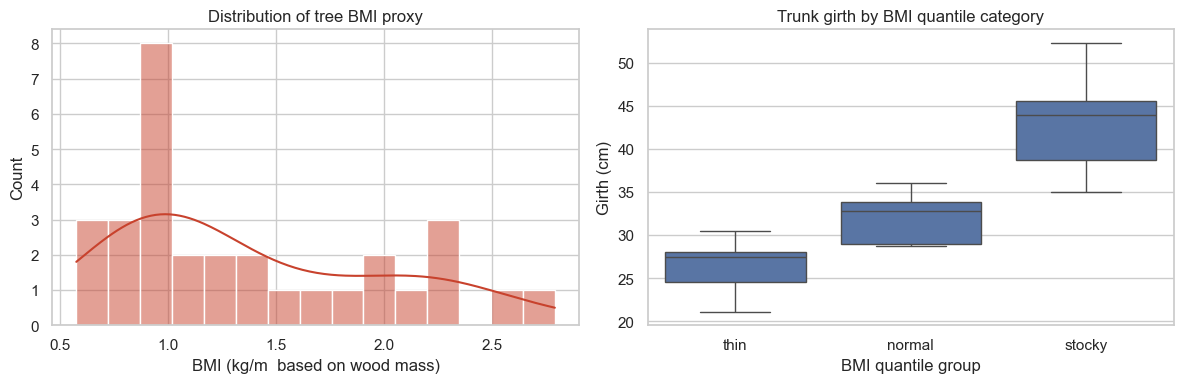

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trees_metric, x='BMI', kde=True, ax=axes[0], color='#c8422d', bins=15)
axes[0].set_title('Distribution of tree BMI proxy')
axes[0].set_xlabel('BMI (kg/m  based on wood mass)')

sns.boxplot(data=trees_metric, x='BMI_category_q', y='Girth_cm', ax=axes[1])
axes[1].set_title('Trunk girth by BMI quantile category')
axes[1].set_xlabel('BMI quantile group')
axes[1].set_ylabel('Girth (cm)')

plt.tight_layout()

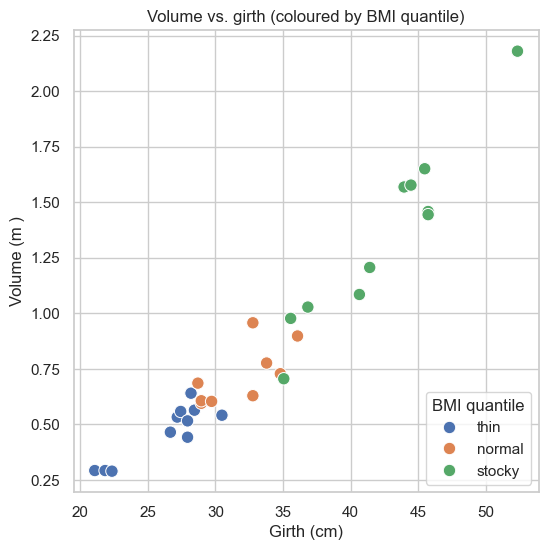

In [63]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=trees_metric, x='Girth_cm', y='Volume_m3', hue='BMI_category_q', s=80)
plt.title('Volume vs. girth (coloured by BMI quantile)')
plt.xlabel('Girth (cm)')
plt.ylabel('Volume (m )')
plt.legend(title='BMI quantile', loc='lower right')
plt.show()

### Pairplot with outlier inspection
A pairplot shows every two-way projection at once, making it easier to spot clusters and potential outliers across the engineered features.

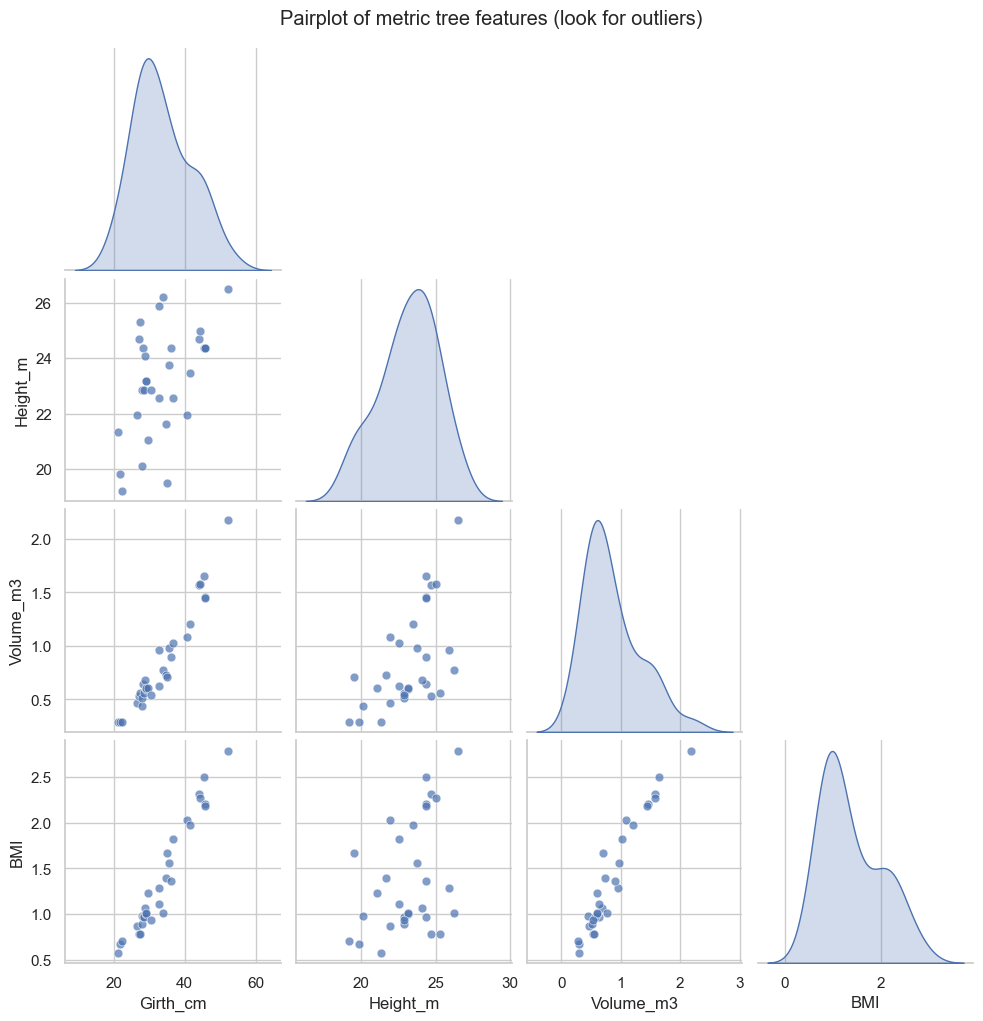

In [64]:
pair_grid = sns.pairplot(
    trees_metric[['Girth_cm', 'Height_m', 'Volume_m3', 'BMI']],
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.7, 's': 40}
)
pair_grid.fig.suptitle('Pairplot of metric tree features (look for outliers)', y=1.02)
plt.show()

### Non-parametric kernel density estimates
Below we compare several kernel choices (Gaussian, Epanechnikov, and uniform) for the main metric variables. Different kernels smooth the distribution differently; a good choice should preserve structure without overfitting noise.

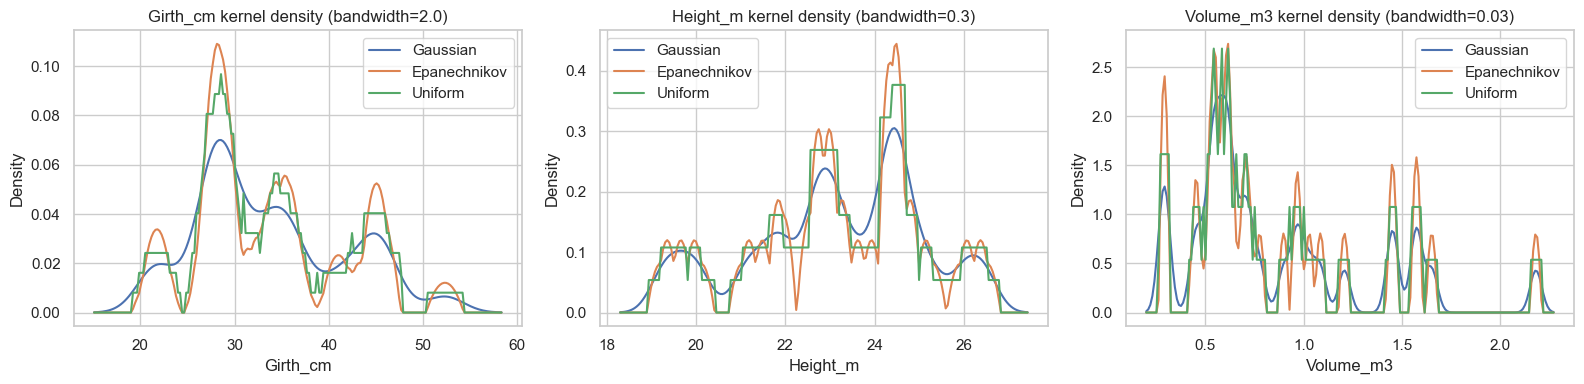

In [65]:
def kernel_density(values, grid, bandwidth, kernel):
    scaled = (grid[:, None] - values[None, :]) / bandwidth
    if kernel == 'gaussian':
        weights = np.exp(-0.5 * scaled ** 2) / np.sqrt(2 * np.pi)
    elif kernel == 'epanechnikov':
        mask = np.abs(scaled) <= 1
        weights = 0.75 * (1 - scaled ** 2) * mask
    elif kernel == 'uniform':
        mask = np.abs(scaled) <= 1
        weights = 0.5 * mask
    else:
        raise ValueError('Unknown kernel')
    density = weights.sum(axis=1) / (len(values) * bandwidth)
    return density

variables = {
    'Girth_cm': (trees_metric['Girth_cm'].to_numpy(), 2.0),
    'Height_m': (trees_metric['Height_m'].to_numpy(), 0.3),
    'Volume_m3': (trees_metric['Volume_m3'].to_numpy(), 0.03)
}

kernels = ['gaussian', 'epanechnikov', 'uniform']
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (name, (values, bandwidth)) in zip(axes, variables.items()):
    grid = np.linspace(values.min() - 3 * bandwidth, values.max() + 3 * bandwidth, 200)
    for kernel in kernels:
        density = kernel_density(values, grid, bandwidth, kernel)
        ax.plot(grid, density, label=kernel.title())
    ax.set_title(f'{name} kernel density (bandwidth={bandwidth})')
    ax.set_xlabel(name)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()

### Normal overlays by BMI category
We can approximate the distribution of timber volume within each BMI quantile group by fitting a normal curve with the group-specific mean and variance. The overlay highlights how well (or poorly) a normal model fits the observed data.

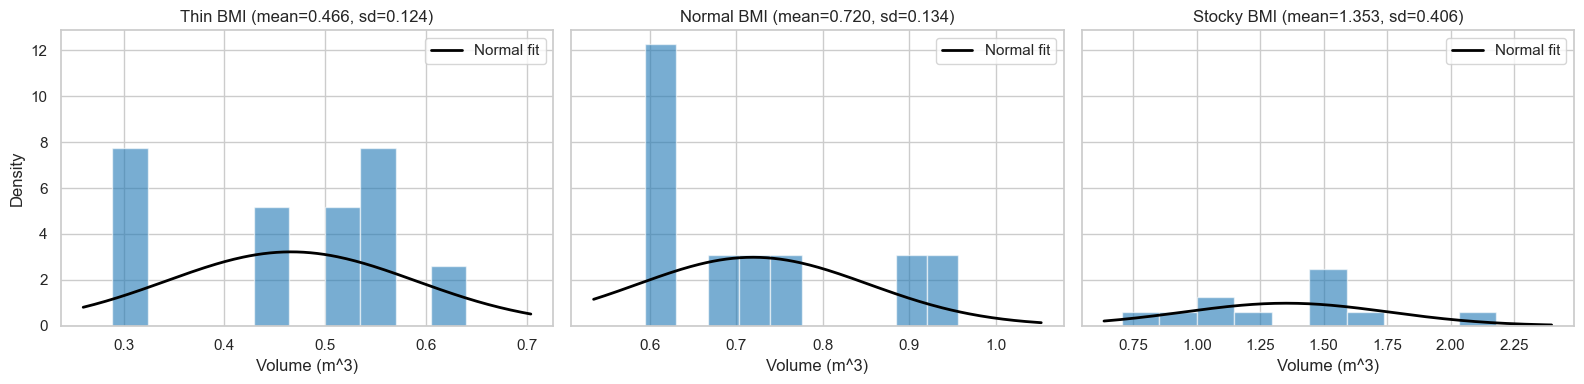

In [66]:
from scipy.stats import norm

categories = ['thin', 'normal', 'stocky']
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, category in zip(axes, categories):
    sample = trees_metric.loc[trees_metric['BMI_category_q'] == category, 'Volume_m3'].dropna()
    if sample.empty:
        ax.text(0.5, 0.5, 'No data in this bin', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{category.title()} BMI')
        ax.set_xlabel('Volume (m^3)')
        continue
    mean = sample.mean()
    std = sample.std(ddof=1)
    support = np.linspace(sample.min() * 0.9, sample.max() * 1.1, 200)
    ax.hist(sample, bins=10, density=True, alpha=0.6, color='#1f77b4', edgecolor='white')
    ax.plot(support, norm.pdf(support, loc=mean, scale=std), color='black', linewidth=2, label='Normal fit')
    ax.set_title(f'{category.title()} BMI (mean={mean:.3f}, sd={std:.3f})')
    ax.set_xlabel('Volume (m^3)')
    ax.legend()

axes[0].set_ylabel('Density')
plt.tight_layout()
plt.show()

### Attention questions
1. What is the purpose of comparing built-in pandas summaries with manual calculations in this notebook?
2. When might you choose quantile-based binning (`pd.qcut`) instead of fixed breakpoints with `pd.cut`?
3. How can the normal overlays per BMI group mislead you if the real distribution is skewed or heavy-tailed?
4. Which visualisation would you check first if a student suspects an outlier in tree volume, and why?
5. How does the choice of kernel and bandwidth in the non-parametric density section influence what you conclude about the data shape?
6. If the R-derived DataFrame did not match the Python version exactly, what debugging steps would you take?
